In [1]:
import pandas as pd
import numpy as np
import math
import time
import datetime as dt
import datetime
from scipy.stats import poisson
from scipy.stats import binom
from scipy.stats import nbinom
import sys
# -*- coding: utf-8 -*-

from scipy.sparse import csr_matrix
from matplotlib.colors import hsv_to_rgb , rgb_to_hsv, LinearSegmentedColormap #,LogNorm, LinearSegmentedColormap, ListedColormap, BoundaryNorm
import pickle
import warnings
import matplotlib.pyplot as plt

PYTHON3 = sys.version_info[0] >= 3

# load HTML engine, if it exists
try:
    if __IPYTHON__:
        from IPython.core.display import HTML
    else:
        HTML = lambda x : x
except NameError:
    HTML = lambda x : x

# Import functions

In [2]:
#########################################################################################

#compute median and CI

def add_median_CI(DF):
    df = DF.copy()
    df['p1'] = df[[i for i in range(n_runs)]].quantile(0.025, axis=1)
    df['median'] = df[[i for i in range(n_runs)]].median(axis=1)
    df['p2'] = df[[i for i in range(n_runs)]].quantile(0.975, axis=1)
    return df

#########################################################################################

# functions to read and manipulate the matrix

#reshape the array in a 4x4 matrix
def keep(df):
    C = []
    for i in range(ages*ages):
        c = df[0][i]
        C.append(c)
    C = np.array(C)
    C = np.reshape(C, (ages,ages))
    return C

#construct the four contact matrices
def extract_matrix(matrix, x_test_a,x_test_s):
    wd = keep(matrix) # healthy behavior (matrix for the individuals in the prodromic phase)
    wd_as = x_test_a*keep(matrix)*0.1 + (1-x_test_a)*keep(matrix)      # asymptomatic
    wd_t = x_test_s*keep(matrix)*0.1 + (1-x_test_s)*keep(matrix)       # pauci-symptomatic and mild
    wd_s = x_test_s*keep(matrix)*0.1 + (1-x_test_s)*keep(matrix)*0.25  # severe symptoms

    return wd,wd_as,wd_t,wd_s

#########################################################################################

def seir(u, parms, t, intervention,     #intervention is a boolean that activates LD1 and the exit strategies 
         LD, TW, scale1, scale2,
         BS_wd, BS_wd_as, BS_wd_t, BS_wd_s,   #matrices for the pre-pandemic phase
         LD_wd, LD_wd_as, LD_wd_t, LD_wd_s,
         TW_wd, TW_wd_as, TW_wd_t, TW_wd_s,   #(list of) weekly matrices for the exit phase (from May 11) 
         projections, proj_scenario, numero_run):

    #quantities of interest
    S = u['S']

    new_E = u['Y_E']
    E = u['E']
    new_I_p = u['Y_I_p']
    I_p = u['I_p']
    new_I_as = u['Y_I_as']
    I_as = u['I_as']
    new_I_ps = u['Y_I_ps']
    I_ps = u['I_ps']
    new_I_ms = u['Y_I_ms']
    I_ms = u['I_ms']
    new_I_ss = u['Y_I_ss']
    I_ss = u['I_ss']
    new_W = u['Y_W']
    W = u['W']
    new_H = u['Y_H']
    H = u['H']
    new_R = u['Y_R']
    R = u['R']
    new_V = u['Y_V']
    
    new_ABpre = u['Y_ABpre']
    ABpre = u['ABpre']
    new_ABpos = u['Y_ABpos']
    ABpos = u['ABpos']
    new_ABneg = u['Y_ABneg']
    ABneg = u['ABneg']
    
    N_tot = u['N_tot']

    bet, sigm, thet, gamm, N, dt = parms
    
    # baseline scenario
    C_h = BS_wd*seasonal[t]
    C_as = BS_wd_as*seasonal[t]
    C_t = BS_wd_t*seasonal[t]
    C_s = BS_wd_s*seasonal[t]
                                      
    if intervention:        
        for week in weeks:
            stage0_start = TW[week][0]
            stage0_end = TW[week][1]

            if (t >= stage0_start) and (t < stage0_end):
                C_h = TW_wd[week]*scale2[week]*seasonal[t]
                C_as = TW_wd_as[week]*scale2[week]*seasonal[t]
                C_t = TW_wd_t[week]*scale2[week]*seasonal[t]
                C_s = TW_wd_s[week]*scale2[week]*seasonal[t]
                
        if t>=TW[weeks[-1]][1]:
            C_h = TW_wd[weeks[-1]]*scale2[weeks[-1]]*seasonal[t]
            C_as = TW_wd_as[weeks[-1]]*scale2[weeks[-1]]*seasonal[t]
            C_t = TW_wd_t[weeks[-1]]*scale2[weeks[-1]]*seasonal[t]
            C_s = TW_wd_s[weeks[-1]]*scale2[weeks[-1]]*seasonal[t]
            
        #if t>=start_scenario:
        #    C_h = TW_wd['summer']*scale2[week_summer]*R0_target/R0_origin
        #    C_as = TW_wd_as['summer']*scale2[week_summer]*R0_target/R0_origin
        #    C_t = TW_wd_t['summer']*scale2[week_summer]*R0_target/R0_origin
        #   C_s = TW_wd_s['summer']*scale2[week_summer]*R0_target/R0_origin
           
            #if t == start_scenario:
            #    print(TW_wd['summer'], scale2[week_summer])
                
    # situation at the previous timestep
    lambd = {}
    
    for variant in variants:
        for status_vax in stati_vax:
            strain = variant+'_'+status_vax
            lambd[strain]=[0]*ages
    
    eta = {'Alpha_dose0': trans_increase['Alpha'], 
           'Delta_dose0': trans_increase['Delta']}
    
    for variant in variants:
        for status_vax in stati_vax:   
            if status_vax!='dose0': 
                strain = variant+'_'+status_vax
                eta[strain]=eta[variant+'_dose0']*(1.0-alpha_trans[strain])
    
    for variant in variants:
        for status_vax in stati_vax:
            strain = variant+'_'+status_vax 
            for age in range(ages):
                l = 0
                for age2 in range(ages):
                    l += eta[strain]*susc[variant][age]*r[age2]*bet*C_h[age,age2]*I_p[strain][age2]/N
                    l += eta[strain]*susc[variant][age]*r[age2]*bet*C_as[age,age2]*I_as[strain][age2]/N
                    l += eta[strain]*susc[variant][age]*r[age2]*bet*C_t[age,age2]*I_ps[strain][age2]/N
                    l += eta[strain]*susc[variant][age]*bet*C_t[age,age2]*I_ms[strain][age2]/N
                    l += eta[strain]*susc[variant][age]*bet*C_s[age,age2]*I_ss[strain][age2]/N
                lambd[strain][age] = l
            lambd[strain] = np.array(lambd[strain])
    
    # compute transition probabilities for entering in each comparment
    
    in_E = {}
    
    for variant in variants:
        tot_lambd = 0
        for status_vax in stati_vax:
            strain = variant+'_'+status_vax  
            tot_lambd += lambd[strain]
            
        for status_vax in stati_vax:
            strain = variant+'_'+status_vax
            if status_vax == 'dose0':
                in_E[strain]= 1.0 - np.exp(-tot_lambd*dt)
            else:
                in_E[strain]= 1.0 - np.exp(-tot_lambd*dt*(1.0-alpha_infect[strain]))
    
    in_I_p={}
    in_I={}
    in_R={}
    in_W={}
    in_H={}
    in_R_from_H={}
    
    in_ABpos={}
    in_ABneg={}
    
    for variant in variants:
        for status_vax in stati_vax:
            strain = variant+'_'+status_vax
        
            #in_I_p[strain]=np.array([sigm*dt]*ages)
            in_I[strain]=np.array([thet*dt]*ages)
            in_R[strain]=np.array([gamm*dt]*ages)
            
            in_W[strain]=np.array([gamm*dt]*ages)
            in_H[strain]=np.array([rate_w*dt]*ages)
            in_R_from_H[strain]=np.array([rate_hosp*dt]*ages)
            
            in_ABpos[strain]=np.array([exit_ABpre*dt]*ages)
            in_ABneg[strain]=np.array([exit_ABpos*dt]*ages)
            
            if variant == 'Alpha':
                in_I_p[strain]=np.array([sigm['alpha']*dt]*ages)
            elif variant =='Delta':
                in_I_p[strain]=np.array([sigm['delta']*dt]*ages)
            else:
                sys.exit()
    
    # transition events (sampled by binomial or multinomial distributions with corresponding transition probabilities)
    
    # infections events
    for age in range(ages):
        
        for status_vax in stati_vax:
            force_of_infection = []
            
            for variant in variants:
                strain = variant+'_'+status_vax
                
                force_of_infection.append(in_E[strain][age])
                
            complem = sum(force_of_infection)
            force_of_infection.append(1.0-complem)
            
            force_of_infection = np.array(force_of_infection)
            
            infections = np.random.multinomial(S[status_vax][age],force_of_infection)
            
            for j,variant in enumerate(variants):
                strain = variant+'_'+status_vax
                new_E[strain][age] = infections[j]
        
    #spontaneous transitions
    
    recovery_as = {}
    recovery_ps = {}
    recovery_ms = {}
    recovery_h = {}
    
    if t < wild_origin:
        list_strains=[]
    else:
        list_strains=[]
        for variant in variants:
            for status_vax in stati_vax:
                strain = variant+'_'+status_vax
                list_strains.append(strain)
        
    for strain in list_strains:
        recovery_as[strain] = [0]*ages
        recovery_ps[strain] = [0]*ages
        recovery_ms[strain] = [0]*ages
        recovery_h[strain] = [0]*ages
        
        for age in range(ages):
            new_I_p[strain][age] = np.random.binomial(E[strain][age],in_I_p[strain][age])

            trans_I = np.array([p_as_v[strain][age]*in_I[strain][age], 
                                p_ps_v[strain][age]*in_I[strain][age], 
                                p_ms_v[strain][age]*in_I[strain][age], 
                                p_ss_v[strain][age]*in_I[strain][age], 
                                1.-in_I[strain][age]])
            #print(trans_I)
            new_I_as[strain][age], new_I_ps[strain][age], new_I_ms[strain][age], new_I_ss[strain][age], res = np.random.multinomial(I_p[strain][age],trans_I)

            recovery_as[strain][age] = np.random.binomial(I_as[strain][age],in_R[strain][age])
            recovery_ps[strain][age] = np.random.binomial(I_ps[strain][age],in_R[strain][age])
            recovery_ms[strain][age] = np.random.binomial(I_ms[strain][age],in_R[strain][age])

            new_W[strain][age] = np.random.binomial(I_ss[strain][age],in_W[strain][age])
            new_H[strain][age] = np.random.binomial(W[strain][age],in_H[strain][age])
            recovery_h[strain][age] = np.random.binomial(H[strain][age], in_R_from_H[strain][age])
            
            new_R[strain][age] = recovery_as[strain][age] + recovery_ps[strain][age] + recovery_ms[strain][age] + recovery_h[strain][age]

            new_ABpre[strain][age] = new_I_p[strain][age]
            new_ABpos[strain][age] = np.random.binomial(ABpre[strain][age],in_ABpos[strain][age])
            new_ABneg[strain][age] = np.random.binomial(ABpos[strain][age],in_ABneg[strain][age])

    #update compartments
    
    for age in range(ages):  
        
        for status_vax in stati_vax:
            
            exit_S = 0
            for variant in variants:
                strain = variant+'_'+status_vax
                exit_S += new_E[strain][age]
                
            S[status_vax][age] = S[status_vax][age] - exit_S

        for strain in list_strains:      
            E[strain][age] = E[strain][age] + new_E[strain][age] - new_I_p[strain][age]
            I_p[strain][age] = I_p[strain][age] + new_I_p[strain][age] - new_I_as[strain][age] - new_I_ps[strain][age] - new_I_ms[strain][age] - new_I_ss[strain][age]
            I_as[strain][age] = I_as[strain][age] + new_I_as[strain][age] - recovery_as[strain][age]
            I_ps[strain][age] = I_ps[strain][age] + new_I_ps[strain][age] - recovery_ps[strain][age]
            I_ms[strain][age] = I_ms[strain][age] + new_I_ms[strain][age] - recovery_ms[strain][age]
            I_ss[strain][age] = I_ss[strain][age] + new_I_ss[strain][age] - new_W[strain][age]
            W[strain][age] = W[strain][age] + new_W[strain][age] - new_H[strain][age]
            H[strain][age] = H[strain][age] + new_H[strain][age] - recovery_h[strain][age]
            R[strain][age] = R[strain][age] + new_R[strain][age]
            ABpre[strain][age] = ABpre[strain][age] + new_ABpre[strain][age] - new_ABpos[strain][age]
            ABpos[strain][age] = ABpos[strain][age] + new_ABpos[strain][age] - new_ABneg[strain][age]
            ABneg[strain][age] = ABneg[strain][age] + new_ABneg[strain][age]
            
        N_tot[age] = 0
        
        for status_vax in stati_vax:
            N_tot[age] += S[status_vax][age]
        
        for strain in list_strains:
            N_tot[age] += E[strain][age]
            N_tot[age] += I_p[strain][age]
            N_tot[age] += I_as[strain][age]
            N_tot[age] += I_ps[strain][age]
            N_tot[age] += I_ms[strain][age]
            N_tot[age] += I_ss[strain][age]
            N_tot[age] += W[strain][age]
            N_tot[age] += H[strain][age]
            N_tot[age] += R[strain][age]

    if t == wild_origin:
        
        dict_config_wild = dict(config_wild.iloc[numero_run])
        
        variant = 'Alpha_dose0'
        
        #initialize wild (alpha variant)
        
        for ii,gg in enumerate(['ch', 'te', 'ad', 'se']):
            E[variant][ii] = int(np.around(dict_config_wild['E_{}'.format(gg)]*(1.-prev_delta)))
            I_p[variant][ii] = int(np.around(dict_config_wild['Ip_{}'.format(gg)]*(1.-prev_delta)))
            I_as[variant][ii] = int(np.around(dict_config_wild['Ias_{}'.format(gg)]*(1.-prev_delta)))
            I_ps[variant][ii] = int(np.around(dict_config_wild['Ips_{}'.format(gg)]*(1.-prev_delta)))
            I_ms[variant][ii] = int(np.around(dict_config_wild['Ims_{}'.format(gg)]*(1.-prev_delta)))
            I_ss[variant][ii] = int(np.around(dict_config_wild['Iss_{}'.format(gg)]*(1.-prev_delta)))
            W[variant][ii] = int(np.around(dict_config_wild['W_{}'.format(gg)]*(1.-prev_delta)))
            H[variant][ii] = int(np.around(dict_config_wild['H_{}'.format(gg)]*(1.-prev_delta)))
            R[variant][ii] = int(np.around(dict_config_wild['R_{}'.format(gg)]*(1.-prev_delta)))
            
            remove = E[variant][ii]+I_p[variant][ii]+I_as[variant][ii]+I_ps[variant][ii]+I_ms[variant][ii]+I_ss[variant][ii]+W[variant][ii]+H[variant][ii]+R[variant][ii]
            S['dose0'][ii] = S['dose0'][ii]-remove
            
        #put vaccination (dynamic)
        for age in [1,2,3]:
            if age == 1: #adolescents
                coverage = vax_init_cond['teen']
                N_age = N_t
            elif age == 2: #adults
                coverage = vax_init_cond['adult']
                N_age = N_a
            elif age == 3: #seniors
                coverage = vax_init_cond['senior']
                N_age = N_s
            else:
                sys.exit()
            
            for status_vax in stati_vax:
                if status_vax != 'dose0':
                    
                    vaccinati = int(np.around(N_age*coverage[status_vax]/100.))
                    
                    if vaccinati > 0:
                    
                        vaccinabili = S['dose0'][age]+R['Alpha_dose0'][age]

                        trans_vax = np.array([S['dose0'][age]/float(vaccinabili),
                                    R['Alpha_dose0'][age]/float(vaccinabili),0])

                        #extract vaccinati from S and R proportionally
                        new_S_vax, new_R_wild_vax, res = np.random.multinomial(vaccinati, trans_vax)

                        vax = min(new_S_vax, S['dose0'][age])
                        S['dose0'][age] = S['dose0'][age]-vax  
                        S[status_vax][age] = S[status_vax][age]+vax

                        vax = min(new_R_wild_vax, R['Alpha_dose0'][age])
                        R['Alpha_dose0'][age] = R['Alpha_dose0'][age]-vax
                        R['Alpha'+'_'+ status_vax][age] = R['Alpha'+'_'+ status_vax][age]+vax
        
    ### insert a VOC case at the end of the day in the third age class (adults):
    if t == VOC_origin: 
        
        dict_config_wild = dict(config_wild.iloc[numero_run])
        
        # initialize VOC (delta variant)
        # in this special case VOC_origin == wild_origin 
        # initialization is: prev_delta*cases for VOC, (1-prev_delta)*cases for wild
        
        for ii,gg in enumerate(['ch', 'te', 'ad', 'se']):
            E['Delta_dose0'][ii] = int(np.around(dict_config_wild['E_{}'.format(gg)]*(prev_delta)))
            I_p['Delta_dose0'][ii] = int(np.around(dict_config_wild['Ip_{}'.format(gg)]*(prev_delta)))
            I_as['Delta_dose0'][ii] = int(np.around(dict_config_wild['Ias_{}'.format(gg)]*(prev_delta)))
            I_ps['Delta_dose0'][ii] = int(np.around(dict_config_wild['Ips_{}'.format(gg)]*(prev_delta)))
            I_ms['Delta_dose0'][ii] = int(np.around(dict_config_wild['Ims_{}'.format(gg)]*(prev_delta)))
            I_ss['Delta_dose0'][ii] = int(np.around(dict_config_wild['Iss_{}'.format(gg)]*(prev_delta)))
            W['Delta_dose0'][ii] = int(np.around(dict_config_wild['H_{}'.format(gg)]*(prev_delta)))
            H['Delta_dose0'][ii] = int(np.around(dict_config_wild['H_{}'.format(gg)]*(prev_delta)))
            R['Delta_dose0'][ii] = int(np.around(dict_config_wild['R_{}'.format(gg)]*(prev_delta)))
            remove = E['Delta_dose0'][ii]+I_p['Delta_dose0'][ii]+I_as['Delta_dose0'][ii]+I_ps['Delta_dose0'][ii]+I_ms['Delta_dose0'][ii]+I_ss['Delta_dose0'][ii]+W['Delta_dose0'][ii]+H['Delta_dose0'][ii]+R['Delta_dose0'][ii]
            S['dose0'][ii] = S['dose0'][ii]-remove        
        
    #VACCINATION
    if t > wild_origin:
        # continue with vaccination
        # administer doses according to data
        one_week=7
        
        for age in [1,2,3]:
            for i, week in enumerate(np.arange(weeks[0], weeks[-1]+100)):
                stage0_start = i*one_week+1
                stage0_end = (i+1)*one_week+1
                
                if (t >= stage0_start) and (t < stage0_end):
                    current_week = week 
                    break
                    
            if (current_week >= start_week_vaccine_proj+vax_delay_eff):
                print('define how to deal with projections of vaccines')
                sys.exit()
                # TRANSIT FROM FIRTS DOSE TO SECOND DOSE COMPARTMENT 
                #in_exit_vax = 1./(7*projected_delay_inter_doses)  ## 3 weeks average time between first dose and second dose in the projected scenarios
                #exit_vax  = np.random.binomial(S['dose1'][age],in_exit_vax)
                #S['dose1'][age]=S['dose1'][age]-exit_vax
                #new_V['dose2-full'][age] += exit_vax
                #S['dose2-full'][age]=S['dose2-full'][age]+exit_vax
                #exit_vax  = np.random.binomial(R['Alpha_dose1'][age],in_exit_vax)
                #R['Alpha_dose1'][age]=R['Alpha_dose1'][age]-exit_vax
                #new_V['dose2-full'][age] += exit_vax
                #R['Alpha_dose2-full'][age]=R['Alpha_dose2-full'][age]+exit_vax
                #exit_vax  = np.random.binomial(R['Delta_dose1'][age],in_exit_vax)
                #R['Delta_dose1'][age]=R['Delta_dose1'][age]-exit_vax
                #new_V['dose2-full'][age] += exit_vax
                #R['Delta_dose2-full'][age]=R['Delta_dose2-full'][age]+exit_vax       

            else: 
                if age == 1: 
                    N_age = N_t
                    max_cov = max_coverage['teen']
                    tag_age = 'teen'
                elif age == 2: 
                    N_age = N_a
                    max_cov = max_coverage['adu']
                    tag_age = 'adult'
                elif age == 3:
                    N_age = N_s
                    max_cov = max_coverage['sen']
                    tag_age = 'senior'
                else:
                    sys.exit()

                new_doses = {}

                condition = past_rollout['date_vax']==(calendar.iloc[t][0]-datetime.timedelta(days=vax_delay_eff*7))
                new_doses['dose1'] = int((N_age/100.)*past_rollout[condition]['%_{}_1d'.format(tag_age)].values[0])

                condition = past_rollout['date_vax']==(calendar.iloc[t][0]-datetime.timedelta(days=vax_delay_waning_3*7))
                new_doses['dose2-waned-3'] = int((N_age/100.)*past_rollout[condition]['%_{}_2d'.format(tag_age)].values[0])

                condition = past_rollout['date_vax']==(calendar.iloc[t][0]-datetime.timedelta(days=vax_delay_waning_2*7))
                new_doses['dose2-waned-2'] = int((N_age/100.)*past_rollout[condition]['%_{}_2d'.format(tag_age)].values[0])

                condition = past_rollout['date_vax']==(calendar.iloc[t][0]-datetime.timedelta(days=vax_delay_waning_1*7))
                new_doses['dose2-waned-1'] = int((N_age/100.)*past_rollout[condition]['%_{}_2d'.format(tag_age)].values[0])

                condition = past_rollout['date_vax']==(calendar.iloc[t][0]-datetime.timedelta(days=vax_delay_eff*7))
                new_doses['dose2-full'] = int((N_age/100.)*past_rollout[condition]['%_{}_2d'.format(tag_age)].values[0])

                condition = past_rollout['date_vax']==(calendar.iloc[t][0]-datetime.timedelta(days=vax_delay_booster_waning_1*7))
                new_doses['dose3-waned'] = int((N_age/100.)*past_rollout[condition]['%_{}_3d'.format(tag_age)].values[0])

                condition = past_rollout['date_vax']==(calendar.iloc[t][0]-datetime.timedelta(days=vax_delay_booster*7))
                new_doses['dose3-full'] = int((N_age/100.)*past_rollout[condition]['%_{}_3d'.format(tag_age)].values[0])

                for status_vax in stati_vax:
                    if status_vax != 'dose0':
                        new_V[status_vax][age]=0     

                perc_vacc_by_dose = {}

                for dose in ['d1', 'd2', 'd3']:
                    if dose == 'd1':
                        list_stati = ['dose1']
                    elif dose == 'd2':
                        #list_stati = ['dose2-full', 'dose2-waned', 'dose2-elig']
                        list_stati = ['dose2-full', 'dose2-waned-1', 'dose2-waned-2', 'dose2-waned-3']
                    elif dose == 'd3':
                        list_stati = ['dose3-full', 'dose3-waned']
                    else:
                        sys.exit()

                    perc_vacc_by_dose[dose] = 0

                    for status_vax in list_stati:
                        perc_vacc_by_dose[dose] += S[status_vax][age]  
                        for variant in variants:
                            perc_vacc_by_dose[dose] += E['{}_{}'.format(variant,status_vax)][age]
                            perc_vacc_by_dose[dose] += I_p['{}_{}'.format(variant,status_vax)][age]
                            perc_vacc_by_dose[dose] += I_as['{}_{}'.format(variant,status_vax)][age]
                            perc_vacc_by_dose[dose] += I_ps['{}_{}'.format(variant,status_vax)][age]
                            perc_vacc_by_dose[dose] += I_ms['{}_{}'.format(variant,status_vax)][age]
                            perc_vacc_by_dose[dose] += I_ss['{}_{}'.format(variant,status_vax)][age]
                            perc_vacc_by_dose[dose] += W['{}_{}'.format(variant,status_vax)][age]
                            perc_vacc_by_dose[dose] += H['{}_{}'.format(variant,status_vax)][age]
                            perc_vacc_by_dose[dose] += R['{}_{}'.format(variant,status_vax)][age]

                perc_vacc_by_dose['d1']=perc_vacc_by_dose['d1']/N_age
                perc_vacc_by_dose['d2']=perc_vacc_by_dose['d2']/N_age
                perc_vacc_by_dose['d3']=perc_vacc_by_dose['d3']/N_age

                perc_vacc = (perc_vacc_by_dose['d1']+perc_vacc_by_dose['d2']+perc_vacc_by_dose['d3'])

                if perc_vacc < max_cov:

                    # FIRST DOSES
                    vaccinabili = S['dose0'][age]+R['Alpha_dose0'][age]+R['Delta_dose0'][age]

                    trans_vax = np.array([S['dose0'][age]/float(vaccinabili), 
                                            R['Alpha_dose0'][age]/float(vaccinabili), 
                                            R['Delta_dose0'][age]/float(vaccinabili),0])

                    if (perc_vacc*N_age + new_doses['dose1']) < max_cov*N_age:
                        new_S_vax, new_R_wild_vax, new_R_VOC_vax, res = np.random.multinomial(new_doses['dose1'], trans_vax)
                    else:
                        doses_ad_hoc = int(max_cov*N_age - perc_vacc*N_age) # which is a smaller value than new_1st_doses
                        new_S_vax, new_R_wild_vax, new_R_VOC_vax, res = np.random.multinomial(doses_ad_hoc, trans_vax)

                    vax = min(new_R_wild_vax,R['Alpha_dose0'][age])
                    new_V['dose1'][age] += vax
                    R['Alpha_dose0'][age] -= vax
                    R['Alpha_dose1'][age] += vax

                    vax = min(new_R_VOC_vax,R['Delta_dose0'][age])
                    new_V['dose1'][age] += vax
                    R['Delta_dose0'][age] -= vax
                    R['Delta_dose1'][age] += vax

                    vax = min(new_S_vax, S['dose0'][age])
                    new_V['dose1'][age] += vax
                    S['dose0'][age] -= vax
                    S['dose1'][age] += vax

                    # OTHER DOSES
                    dict_source = dict(zip(stati_vax[2:],stati_vax[1:-1]))

                    for status_vax in dict_source.keys():

                        source = dict_source[status_vax]

                        vaccinabili = S[source][age]+R['Alpha_{}'.format(source)][age]+R['Delta_{}'.format(source)][age]

                        if vaccinabili > 0 :
                            
                            trans_vax = np.array([S[source][age]/float(vaccinabili), 
                                                R['Alpha_{}'.format(source)][age]/float(vaccinabili), 
                                                R['Delta_{}'.format(source)][age]/float(vaccinabili),0])
                            
                            #print(t,status_vax,trans_vax)

                            new_S_vax, new_R_wild_vax, new_R_VOC_vax, res = np.random.multinomial(new_doses[status_vax], trans_vax)

                            vax = min(new_R_wild_vax,R['Alpha_{}'.format(source)][age])
                            new_V[status_vax][age] += vax
                            R['Alpha_{}'.format(source)][age] -= vax
                            R['Alpha_{}'.format(status_vax)][age] += vax

                            vax = min(new_R_VOC_vax,R['Delta_{}'.format(source)][age])
                            new_V[status_vax][age] += vax
                            R['Delta_{}'.format(source)][age] -= vax
                            R['Delta_{}'.format(status_vax)][age] += vax

                            vax = min(new_S_vax, S[source][age])
                            new_V[status_vax][age] += vax
                            S[source][age] -= vax
                            S[status_vax][age] += vax
            
    return  {'t':t, 'S': S, 'E':E, 'I_p':I_p, 
             'I_as':I_as,'I_ps':I_ps,'I_ms':I_ms,'I_ss':I_ss, 'H':H, 'R':R,
             'Y_E':new_E,'Y_I_p':new_I_p,'Y_I_as':new_I_as,
             'Y_I_ps':new_I_ps,'Y_I_ms':new_I_ms,'Y_I_ss':new_I_ss,
             'Y_H':new_H, 'Y_R':new_R, 
             'Y_V': new_V, 
             'Y_W': new_W, 'W': W,
             'ABpre':ABpre, 'ABpos':ABpos, 'ABneg':ABneg, 
             'Y_ABpre':new_ABpre, 'Y_ABpos':new_ABpos, 'Y_ABneg':new_ABneg, 
             'N_tot':N_tot}  

def simulate(beta,lag,intervention, 
             LD, TW, scale1,scale2,
             BS_wd,BS_wd_as, BS_wd_t, BS_wd_s,
             LD_wd,LD_wd_as, LD_wd_t, LD_wd_s,
             TW_wd,TW_wd_as, TW_wd_t, TW_wd_s,
             projections, proj_scenario, numero_run):
    
    parms = [beta, sigma, theta, gamma, N, delta_t]
    
    tf = t_stop
    
    t = np.arange(tf)
    
    S = {}
    Y_V = {}
    
    for status_vax in stati_vax:
        
        S[status_vax] = np.zeros((tf,ages))
        
        if status_vax != 'dose0':
            Y_V[status_vax] = np.zeros((tf,ages))
    
    E={}
    I_p={}
    I_as={}
    I_ps={}
    I_ms={}
    I_ss={}
    W={}
    H={}
    R={}
    Y_E={}
    Y_I_p={}
    Y_I_as={}
    Y_I_ps={}
    Y_I_ms={}
    Y_I_ss={}
    Y_W={}
    Y_H={}
    Y_R={}
    
    ABpre={}
    ABpos={}
    ABneg={}
    Y_ABpre={}
    Y_ABpos={}
    Y_ABneg={}
    
    for variant in variants:
        for status_vax in stati_vax:
            strain = variant+'_'+status_vax
        
            E[strain]=np.zeros((tf,ages))
            I_p[strain]=np.zeros((tf,ages))
            I_as[strain]=np.zeros((tf,ages))
            I_ps[strain]=np.zeros((tf,ages))
            I_ms[strain]=np.zeros((tf,ages))
            I_ss[strain]=np.zeros((tf,ages))
            W[strain]=np.zeros((tf,ages))
            H[strain]=np.zeros((tf,ages))
            R[strain]=np.zeros((tf,ages))

            Y_E[strain]=np.zeros((tf,ages))
            Y_I_p[strain]=np.zeros((tf,ages))
            Y_I_as[strain]=np.zeros((tf,ages))
            Y_I_ps[strain]=np.zeros((tf,ages))
            Y_I_ms[strain]=np.zeros((tf,ages))
            Y_I_ss[strain]=np.zeros((tf,ages))
            Y_W[strain]=np.zeros((tf,ages))
            Y_H[strain]=np.zeros((tf,ages))
            Y_R[strain]=np.zeros((tf,ages))

            ABpre[strain]=np.zeros((tf,ages))
            Y_ABpre[strain]=np.zeros((tf,ages))
            ABpos[strain]=np.zeros((tf,ages))
            Y_ABpos[strain]=np.zeros((tf,ages))
            ABneg[strain]=np.zeros((tf,ages))
            Y_ABneg[strain]=np.zeros((tf,ages))
    
    N_tot = np.zeros((tf,ages))
    
    result = {'t':t, 'S': S, 
              'E':E, 'I_p':I_p, 
              'I_as':I_as,'I_ps':I_ps,'I_ms':I_ms,'I_ss':I_ss, 'W':W, 'H':H,'R':R,
              'Y_E':Y_E,'Y_I_p':Y_I_p,
              'Y_I_as':Y_I_as,'Y_I_ps':Y_I_ps,'Y_I_ms':Y_I_ms,'Y_I_ss':Y_I_ss,
              'Y_H':Y_H,'Y_R':Y_R,'Y_V': Y_V, 'Y_W': Y_W, 
              'ABpre':ABpre, 'ABpos':ABpos, 'ABneg':ABneg, 
              'Y_ABpre':Y_ABpre, 'Y_ABpos':Y_ABpos, 'Y_ABneg':Y_ABneg,
              'N_tot':N_tot}

    #initial condition
    
    u = {'t':0}
    
    u['S'] = {}
    u['Y_V'] = {}
    
    for status_vax in stati_vax:
        if status_vax == 'dose0':
            u['S'][status_vax] = [N_c,N_t,N_a-I_iniz,N_s]
        else:
            u['S'][status_vax] = [0]*ages
            u['Y_V'][status_vax] = [0]*ages
            
    
    u['N_tot'] = [N_c,N_t,N_a,N_s]

    # seed
    
    u['I_p'] = {}
    
    for variant in variants:
        for status_vax in stati_vax:
            strain = variant+'_'+status_vax
            
            if strain == 'Alpha_dose0':
                u['I_p'][strain] = [0,0,I_iniz,0]
            else:
                u['I_p'][strain] = [0]*ages
         
    for key in ['E','I_as','I_ps', 'I_ms', 'I_ss','W','H','R',
                'Y_E','Y_I_p','Y_I_as','Y_I_ps','Y_I_ms','Y_I_ss','Y_W','Y_H', 'Y_R',
                 'Y_ABpre', 'ABpre', 'Y_ABpos',  'ABpos', 'Y_ABneg', 'ABneg']:
        
        u[key] = {}
        
        for variant in variants:
            for status_vax in stati_vax:
                strain = variant+'_'+status_vax
                
                u[key][strain] = [0]*ages

    for c in result.keys():
        #e.g. result['I_p'] is a dictionary with two keys, wild and VOC
        #result['I_p']['Alpha_dose0'] is an array with length = t_stop
        #each elements is a list with length = ages
        #result['I_p']['Alpha_dose0'] is initialized with zeros
        #I insert in the first position the list [0,0,I_iniz,0] which indicates the initial condition
        if c not in ['t','S','N_tot','Y_V']:
            for variant in variants:
                for status_vax in stati_vax:
                    strain = variant+'_'+status_vax
                    result[c][strain][0] = u[c][strain]
                    
        elif c =='S':
            for status_vax in stati_vax:
                result[c][status_vax][0] = u[c][status_vax]
        elif c=='Y_V':
            for status_vax in stati_vax:
                if status_vax != 'dose0':
                    result[c][status_vax][0] = u[c][status_vax]           
        else:
            result[c][0] = u[c]
    
    for j in range(1,tf):
        #j is the time index
        u = seir(u,parms,t[j],intervention, LD, TW, scale1,scale2,
                 BS_wd,BS_wd_as, BS_wd_t, BS_wd_s,
                 LD_wd,LD_wd_as, LD_wd_t, LD_wd_s,
                 TW_wd,TW_wd_as, TW_wd_t, TW_wd_s,
                 projections, proj_scenario, numero_run) 
        
        for c in result.keys():#list of compartments
            #I insert in position j the list [x,x,x,x] which indicates number of individuals 
            #in compartment c with strain at the timestep j
            if c not in ['t','S','N_tot', 'Y_V']:
                for variant in variants:
                    for status_vax in stati_vax:
                        strain = variant+'_'+status_vax
                        result[c][strain][j] = u[c][strain]
            elif c =='S':
                for status_vax in stati_vax:
                    result[c][status_vax][j] = u[c][status_vax]
            elif c=='Y_V':
                for status_vax in stati_vax:
                    if status_vax != 'dose0':
                        result[c][status_vax][j] = u[c][status_vax]    
            else:
                result[c][j] = u[c]
    
            
    return result

def run_simulation(beta,lag,intervention = False, 
                   LD = [[0,0]], TW = 0,
                   scale1=0,scale2=0,
                   x_test_a=0,x_test_s=0, 
                   projections = False, proj_scenario = 'none'):
    
    #read matrices
    
    #prelockdown
    BS_wd_h = pd.read_table(initial_path_matrices+'/base_wd.txt', header = None, sep=' ')
 
    #lockdown
    LD_wd_h = pd.read_table(initial_path_matrices+'/matrix_LD/LD_matrixC_flat.txt', header = None, sep=' ')
   
    #post-lockdown
    
    TW_wd_h={}
    
    TW_wd={}
    TW_wd_as={}
    TW_wd_t={}
    TW_wd_s={}

    #weeks should goes from 20 (w20 = May 11 - May 18) to ....
    for week in weeks:
        if week<=26:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')
        elif week>26 and week<=35:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')          
        elif week>35 and week<=42:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat1_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')
        elif week>42 and week<=44:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')
        elif week in [45,46,47]:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat1_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')
        elif week in [48, 49, 50, 51]:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat1_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ') 
        elif week in [52, 53]: ####(ttt>=52)
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ') 
        elif week in [54,55,56,57,58]:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat2_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ') 
        elif week in [53+6, 53+7, 53+8]:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ') 
        elif week in [53+9]:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat3_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ') 
        elif week in [53+10, 53+11, 53+12, 53+13]:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat3_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')      
        elif week in [53+14]:
            # one week of schools closed (remote school)
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')     
        elif week in [53+15, 53+16]:
            # two weeks of school holidays
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')      
        elif week in [53+17]:
            # one week of remote school for teenagers only (childre 100% in school)
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')      
        elif week >= 53+18 and week <=53+26:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat3_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')     
        elif (week >= 53+27 and week <= 53+34):
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')      
        elif (week >= 53+35 and week <= 53+42):  ### rentree
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat5_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')       
        elif week in [53+43,53+44]:  ### school holidays
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')         
        elif week in [53+45, 53+46, 53+47, 53+48]:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat5_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')  
        elif week >= 53+48:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat5_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ') 
        else:
            sys.exit()  
            
    #old notation: TW = [[0 for col in range(2)] for row in range(len(weeks))]
    TW = {}
    for week in weeks:
        TW[week] = [0,0]
        
    one_week = 7
    
    for i, week in enumerate(weeks):
        TW[week][0] = i*one_week+1
        TW[week][1] = (i+1)*one_week+1

    
    for week in weeks:
        TW_wd[week], TW_wd_as[week], TW_wd_t[week], TW_wd_s[week] = extract_matrix(TW_wd_h[week],
                                                                                   x_test_a=x_test_a[week],
                                                                                   x_test_s=x_test_s[week])
        
    #path_matrix=initial_path2+'/matrices/exit-holidays_w4344_holiday_matrix/matrix_reg{}_week{}_SI0.0.txt'.format(reg,week_summer)
    #TW_wd_h['summer']=pd.read_table(path_matrix, header = None, sep=' ')
    #TW_wd['summer'], TW_wd_as['summer'], TW_wd_t['summer'], TW_wd_s['summer'] = extract_matrix(TW_wd_h['summer'],
    #                                                                           x_test_a=x_test_a[week_summer],
    #                                                                           x_test_s=x_test_s[week_summer])


    BS_wd,BS_wd_as, BS_wd_t, BS_wd_s = extract_matrix(BS_wd_h,x_test_a=0,x_test_s=0)
    LD_wd,LD_wd_as, LD_wd_t, LD_wd_s = extract_matrix(LD_wd_h,x_test_a=0,x_test_s=0)
        
    #initialize dataframes to contain the results of each simulation
       
    out_prev_comp = {}
    
    for age in range(ages):
        for ccc in ['S','E', 'I_p', 'I_as', 'I_ps', 'I_ms', 'I_ss', 'W', 'H', 'R', 'ABpre', 'ABpos', 'ABneg']:
            for status_vax in stati_vax:
                compart = '{}_age{}_{}'.format(ccc,age,status_vax)
                out_prev_comp[compart]=pd.DataFrame(np.arange(t_stop))

                
    out_E = {}
    out_I_p = {}
    out_I_as = {}
    out_I_ps = {}
    out_I_ms = {}
    out_I_ss = {}
    out_HU = {}
    out_symp = {}
    out_asym = {}
    out_cases = {}
    
    out_Y_E_by_vax_age = {}
    out_Y_H_by_vax_age = {} 
    
    out_Y_Ias_by_vax_age = {}
    out_Y_Ips_by_vax_age = {} 
    out_Y_Ims_by_vax_age = {}
    out_Y_Iss_by_vax_age = {} 

    for variant in variants:
        for status_vax in stati_vax:
            strain = variant+'_'+status_vax
            out_E[strain]= pd.DataFrame(np.arange(t_stop))
            out_I_p[strain]= pd.DataFrame(np.arange(t_stop))
            out_I_as[strain]= pd.DataFrame(np.arange(t_stop))
            out_I_ps[strain]= pd.DataFrame(np.arange(t_stop))
            out_I_ms[strain]= pd.DataFrame(np.arange(t_stop))
            out_I_ss[strain]= pd.DataFrame(np.arange(t_stop))
            out_HU[strain]= pd.DataFrame(np.arange(t_stop))
            out_symp[strain]= pd.DataFrame(np.arange(t_stop))
            out_asym[strain]= pd.DataFrame(np.arange(t_stop))
            out_cases[strain]= pd.DataFrame(np.arange(t_stop))
        
            for age in range(ages):
                age = str(age)
                out_Y_E_by_vax_age[strain+'_'+age] = pd.DataFrame(np.arange(t_stop))
                out_Y_H_by_vax_age[strain+'_'+age] = pd.DataFrame(np.arange(t_stop))
                out_Y_Ias_by_vax_age[strain+'_'+age] = pd.DataFrame(np.arange(t_stop))
                out_Y_Ips_by_vax_age[strain+'_'+age] = pd.DataFrame(np.arange(t_stop))
                out_Y_Ims_by_vax_age[strain+'_'+age] = pd.DataFrame(np.arange(t_stop))
                out_Y_Iss_by_vax_age[strain+'_'+age] = pd.DataFrame(np.arange(t_stop))

    ################   NEW ########################################################
    out_Y_E_ch = pd.DataFrame(np.arange(t_stop))
    out_Y_E_teen = pd.DataFrame(np.arange(t_stop))
    out_Y_E_adu = pd.DataFrame(np.arange(t_stop))
    out_Y_E_sen = pd.DataFrame(np.arange(t_stop))
    out_Y_E_all = pd.DataFrame(np.arange(t_stop))
    
    out_Y_H_ch = pd.DataFrame(np.arange(t_stop))
    out_Y_H_teen = pd.DataFrame(np.arange(t_stop))
    out_Y_H_adu = pd.DataFrame(np.arange(t_stop))
    out_Y_H_sen = pd.DataFrame(np.arange(t_stop))
    out_Y_H_all = pd.DataFrame(np.arange(t_stop))
    
    out_ABpos_ch = pd.DataFrame(np.arange(t_stop))
    out_ABpos_teen = pd.DataFrame(np.arange(t_stop))
    out_ABpos_adu = pd.DataFrame(np.arange(t_stop))
    out_ABpos_sen = pd.DataFrame(np.arange(t_stop))
    out_ABpos_all = pd.DataFrame(np.arange(t_stop))
    
    out_ABneg_ch = pd.DataFrame(np.arange(t_stop))
    out_ABneg_teen = pd.DataFrame(np.arange(t_stop))
    out_ABneg_adu = pd.DataFrame(np.arange(t_stop))
    out_ABneg_sen = pd.DataFrame(np.arange(t_stop))
    out_ABneg_all = pd.DataFrame(np.arange(t_stop))
    
    out_Y_E_by_vax = {}
    out_Y_H_by_vax = {}
    
    for status_vax in stati_vax:
        out_Y_E_by_vax[status_vax]=pd.DataFrame(np.arange(t_stop))
        out_Y_H_by_vax[status_vax]=pd.DataFrame(np.arange(t_stop))

    out_N = pd.DataFrame(np.arange(t_stop))
    out_S = pd.DataFrame(np.arange(t_stop))
        
    perc_vax_sen = {}
    perc_vax_adu = {}
    perc_vax_teen = {}
    
    new_vax_teen = {}
    new_vax_adu = {}
    new_vax_sen = {}
    
    for status_vax in stati_vax:
        perc_vax_sen[status_vax] = pd.DataFrame(np.arange(t_stop))
        perc_vax_adu[status_vax] = pd.DataFrame(np.arange(t_stop))
        perc_vax_teen[status_vax] = pd.DataFrame(np.arange(t_stop))
        
        new_vax_sen[status_vax] = pd.DataFrame(np.arange(t_stop))
        new_vax_adu[status_vax] = pd.DataFrame(np.arange(t_stop))
        new_vax_teen[status_vax] = pd.DataFrame(np.arange(t_stop))
    
    #for each run
    for n in range(n_runs):
        out = simulate(beta,lag,intervention, LD, TW, scale1,scale2,
                       BS_wd,BS_wd_as, BS_wd_t, BS_wd_s,
                       LD_wd,LD_wd_as, LD_wd_t, LD_wd_s,
                       TW_wd,TW_wd_as, TW_wd_t, TW_wd_s,
                       projections, proj_scenario, n)
        # extract quantities of interest, e.g. number of recovered or incidence
        # save the timeseries in the column of a dataframe    
        # save the timeseries in the column of a dataframe   
        
        for variant in variants:
            for status_vax in stati_vax:
                strain = variant+'_'+status_vax
                out_E[strain][n] = pd.DataFrame(out['Y_E'][strain]).sum(axis=1)
                out_I_as[strain][n] = pd.DataFrame(out['Y_I_as'][strain]).sum(axis=1)
                out_I_ps[strain][n] = pd.DataFrame(out['Y_I_ps'][strain]).sum(axis=1)
                out_I_ms[strain][n] = pd.DataFrame(out['Y_I_ms'][strain]).sum(axis=1)
                out_I_ss[strain][n] = pd.DataFrame(out['Y_I_ss'][strain]).sum(axis=1)
                out_HU[strain][n] = pd.DataFrame(out['Y_H'][strain]).sum(axis=1)

                out_asym[strain][n] = out_I_as[strain][n]
                out_symp[strain][n] = out_I_ps[strain][n]+out_I_ms[strain][n]+out_I_ss[strain][n]
                out_cases[strain][n] = out_asym[strain][n] + out_symp[strain][n]
            
        out_N[n] = pd.DataFrame(out['N_tot']).sum(axis=1)
        
        for status_vax in stati_vax:
            
            summ = out['S'][status_vax].copy()
            for variant in variants:
                strain = variant+'_'+status_vax
                summ += out['E'][strain]+out['I_p'][strain]+out['I_as'][strain]+out['I_ps'][strain]+out['I_ms'][strain]+out['I_ss'][strain]+out['H'][strain]+out['R'][strain]
                
            perc_vax_teen[status_vax][n] = pd.DataFrame(summ)[1]/N_t
            perc_vax_adu[status_vax][n] = pd.DataFrame(summ)[2]/N_a
            perc_vax_sen[status_vax][n] = pd.DataFrame(summ)[3]/N_s
            
            if status_vax != 'dose0':
     
                new_vax_teen[status_vax][n] = 100*pd.DataFrame(out['Y_V'][status_vax])[1]/N_t
                new_vax_adu[status_vax][n] = 100*pd.DataFrame(out['Y_V'][status_vax])[2]/N_a
                new_vax_sen[status_vax][n] = 100*pd.DataFrame(out['Y_V'][status_vax])[3]/N_s
 
        out_Y_E_ch[n] = 0
        out_Y_E_teen[n] = 0
        out_Y_E_adu[n] = 0
        out_Y_E_sen[n] = 0
        out_Y_E_all[n] = 0
        
        out_Y_H_ch[n] = 0
        out_Y_H_teen[n] = 0
        out_Y_H_adu[n] = 0
        out_Y_H_sen[n] = 0
        out_Y_H_all[n] = 0
        
        out_ABpos_ch[n] = 0
        out_ABpos_teen[n] = 0
        out_ABpos_adu[n] = 0
        out_ABpos_sen[n] = 0
        out_ABpos_all[n] = 0

        out_ABneg_ch[n] = 0
        out_ABneg_teen[n] = 0
        out_ABneg_adu[n] = 0
        out_ABneg_sen[n] = 0
        out_ABneg_all[n] = 0
        
        for variant in variants:
            for status_vax in stati_vax:
                strain = variant+'_'+status_vax  

                out_Y_E_ch[n] += pd.DataFrame(out['Y_E'][strain])[0]
                out_Y_E_teen[n] += pd.DataFrame(out['Y_E'][strain])[1]
                out_Y_E_adu[n] += pd.DataFrame(out['Y_E'][strain])[2]
                out_Y_E_sen[n] += pd.DataFrame(out['Y_E'][strain])[3]
                out_Y_E_all[n] += pd.DataFrame(out['Y_E'][strain]).sum(axis=1)
                
                out_Y_H_ch[n] += pd.DataFrame(out['Y_H'][strain])[0]
                out_Y_H_teen[n] += pd.DataFrame(out['Y_H'][strain])[1]
                out_Y_H_adu[n] += pd.DataFrame(out['Y_H'][strain])[2]
                out_Y_H_sen[n] += pd.DataFrame(out['Y_H'][strain])[3]
                out_Y_H_all[n] += pd.DataFrame(out['Y_H'][strain]).sum(axis=1)
                
                out_ABpos_ch[n] += pd.DataFrame(out['ABpos'][strain])[0]
                out_ABpos_teen[n] += pd.DataFrame(out['ABpos'][strain])[1]
                out_ABpos_adu[n] += pd.DataFrame(out['ABpos'][strain])[2]
                out_ABpos_sen[n] += pd.DataFrame(out['ABpos'][strain])[3]
                out_ABpos_all[n] += pd.DataFrame(out['ABpos'][strain]).sum(axis=1)

                out_ABneg_ch[n] += pd.DataFrame(out['ABneg'][strain])[0]
                out_ABneg_teen[n] += pd.DataFrame(out['ABneg'][strain])[1]
                out_ABneg_adu[n] += pd.DataFrame(out['ABneg'][strain])[2]
                out_ABneg_sen[n] += pd.DataFrame(out['ABneg'][strain])[3]
                out_ABneg_all[n] += pd.DataFrame(out['ABneg'][strain]).sum(axis=1)
                
                for age in range(ages):
                    age = str(age)
                    out_Y_H_by_vax_age[strain+'_'+age][n] = pd.DataFrame(out['Y_H'][strain])[int(age)]
                    out_Y_E_by_vax_age[strain+'_'+age][n] = pd.DataFrame(out['Y_E'][strain])[int(age)]
                    out_Y_Ias_by_vax_age[strain+'_'+age][n] = pd.DataFrame(out['Y_I_as'][strain])[int(age)]
                    out_Y_Ips_by_vax_age[strain+'_'+age][n] = pd.DataFrame(out['Y_I_ps'][strain])[int(age)]
                    out_Y_Ims_by_vax_age[strain+'_'+age][n] = pd.DataFrame(out['Y_I_ms'][strain])[int(age)]
                    out_Y_Iss_by_vax_age[strain+'_'+age][n] = pd.DataFrame(out['Y_I_ss'][strain])[int(age)]
                
                
        for status_vax in stati_vax:
            out_Y_H_by_vax[status_vax][n]=0
            out_Y_E_by_vax[status_vax][n]=0
            for variant in variants:
                strain = variant+'_'+status_vax  
                out_Y_H_by_vax[status_vax][n] += pd.DataFrame(out['Y_H'][strain]).sum(axis=1)
                out_Y_E_by_vax[status_vax][n] += pd.DataFrame(out['Y_E'][strain]).sum(axis=1)
                
        for age in range(ages):
            for ccc in ['S', 'E', 'I_p', 'I_as', 'I_ps', 'I_ms', 'I_ss', 'W', 'H', 'R',  'ABpre', 'ABpos', 'ABneg']:
                for status_vax in stati_vax:
                    compart = '{}_age{}_{}'.format(ccc,age,status_vax)
                    if ccc != 'S':
                        out_prev_comp[compart][n]=pd.DataFrame(out[ccc]['Alpha_{}'.format(status_vax)]+out[ccc]['Delta_{}'.format(status_vax)])[age]
                    else:
                        out_prev_comp[compart][n]=pd.DataFrame(out[ccc]['{}'.format(status_vax)])[age]
                
        
    return {'perc_vax_sen': perc_vax_sen,
            'perc_vax_adu': perc_vax_adu,
            'perc_vax_teen': perc_vax_teen,
            'new_vax_teen': new_vax_teen, 'new_vax_adu': new_vax_adu,'new_vax_sen': new_vax_sen,
            'ABpos_ch':out_ABpos_ch, 'ABpos_teen':out_ABpos_teen, 
            'ABpos_adu':out_ABpos_adu, 'ABpos_sen':out_ABpos_sen, 
            'ABpos_all':out_ABpos_all,
            
            'ABneg_ch':out_ABneg_ch, 'ABneg_teen':out_ABneg_teen, 
            'ABneg_adu':out_ABneg_adu, 'ABneg_sen':out_ABneg_sen, 
            'ABneg_all':out_ABneg_all,
            'new_E': out_E, 'new_H':out_HU,
            'new_Ias': out_I_as, 'new_Ips': out_I_ps, 'new_Ims':out_I_ms, 'new_Iss':out_I_ss,
            'new_symp': out_symp,'new_asym': out_asym, 'new_cases': out_cases, 'pop': out_N,
            'new_infections_ch':out_Y_E_ch, 'new_infections_teen':out_Y_E_teen, 
            'new_infections_adu':out_Y_E_adu, 'new_infections_sen':out_Y_E_sen, 
            'new_infections_all':out_Y_E_all,
            'new_H_admissions_ch':out_Y_H_ch, 'new_H_admissions_teen':out_Y_H_teen, 
            'new_H_admissions_adu':out_Y_H_adu, 'new_H_admissions_sen':out_Y_H_sen, 
            'new_H_admissions_all':out_Y_H_all,
            'new_H_by_vax': out_Y_H_by_vax, 'new_E_by_vax': out_Y_E_by_vax,
            'new_H_by_vax_age': out_Y_H_by_vax_age, 'new_E_by_vax_age': out_Y_E_by_vax_age,
            'new_Ias_by_vax_age': out_Y_Ias_by_vax_age, 'new_Ips_by_vax_age': out_Y_Ips_by_vax_age,
            'new_Ims_by_vax_age': out_Y_Ims_by_vax_age, 'new_Iss_by_vax_age': out_Y_Iss_by_vax_age,
            'prev_comp': out_prev_comp}

In [3]:
codice_regione = 'France'

reg = codice_regione

# set names of variants and vaccination status

In [4]:
variants = ['Alpha', 'Delta']
stati_vax = ['dose0', 'dose1', 
             'dose2-full', 'dose2-waned-1','dose2-waned-2','dose2-waned-3',
             'dose3-full', 'dose3-waned']

## INPUT

In [5]:
#data pop and data hosp
initial_path='./../..'

#matrices
initial_path_matrices='./../../matrices_empirical_SocialCov/'

## MAIN

### details of the simulations

In [6]:
I_iniz = 0  # seed (adults in prodromic phase)

ages = 4  #number of age classes

n_runs = 500 # number of runs

delta_t = 1 #timestep (days), e.g. delta_t=1 means a timestep of 1 day

In [7]:
calibr = pd.read_csv('./../../other_inputs/calibration.csv', sep = ';')
calibr.tail()

,reg,ss_children,ss_adoles,ss_adults,ss_seniors,beta,alpha_LD,delay,lag,suscep-wuhan,suscep-VOC,SI,adu-sen-adj-factor,infectious-period,compartment-W,population,seasonality,loglikelihood,matrices,calibration-target
96,France,0.4,0.16,1.84,16.07,0.086,0.84,-2.0,45,[0.7 0.7 1. 1. ],"[1.0, 1.0, 1.0, 1.0]",0.0,1.6,2.0,3.0,new,no,-2851.913841,synthetic_matrices_revised_baseline&eq_physica...,age-stratified-fit-serology
97,France,0.4,0.16,1.84,16.07,0.086,1.18,-3.0,45,[0.7 0.7 1. 1. ],"[1.0, 1.0, 1.0, 1.0]",0.0,1.6,2.0,3.0,new,no,-3193.136350,synthetic_matrices_revised_baseline&eq_physica...,age-stratified-fit-serology
98,France,0.4,0.16,1.84,16.07,0.086,1.18,-3.0,45,[0.7 0.7 1. 1. ],"[0.7, 0.7, 1.0, 1.0]",0.0,1.6,2.0,3.0,new,no,-3072.530636,synthetic_matrices_revised_baseline&eq_physica...,age-stratified-fit-serology
99,France,0.4,0.16,1.84,16.07,0.086,1.08,-2.0,45,[0.7 0.7 1. 1. ],"[0.7, 0.7, 1.0, 1.0]",0.0,1.6,2.0,3.0,new,no,-3774.018422,FR_SocialCov,age-stratified-fit-serology
100,France,0.4,0.16,1.84,16.07,0.086,0.26,-2.0,45,[0.7 0.7 1. 1. ],"[0.7, 0.7, 1.0, 1.0]",0.0,1.6,2.0,3.0,new,no,-2894.451403,only-baseline-revised,age-stratified-fit-serology


In [8]:
choose = 90

ss_children_input = np.around(calibr.iloc[choose].ss_children/100,4)
ss_teens_input = np.around(calibr.iloc[choose].ss_adoles/100,4)
ss_adults_input = np.around(calibr.iloc[choose].ss_adults/100,4)
ss_seniors_input = np.around(calibr.iloc[choose].ss_seniors/100,4)

if calibr.iloc[choose].reg!=str(reg):
    sys.exit()
    
ss_teens_input, ss_adults_input, ss_seniors_input

(0.0016, 0.0184, 0.1607)

In [9]:
senior_isolation = calibr.iloc[choose].SI
senior_isolation

0.0

In [10]:
calibr.iloc[choose]['infectious-period']

2.0

In [11]:
calibr.iloc[choose]['matrices']

'FR_SocialCov'

In [12]:
calibr.iloc[choose]['calibration-target']

'age-stratified-fit-serology'

### epidemiological parameters

In [13]:
incubation = 3.7       # incubation period (non infectious) (days)
prodromic = 1.5        # prodromic phase (I_p)
infection = calibr.iloc[choose]['infectious-period']
waiting = 3.0          # waiting comparment so that onset-hospitalization delay is 2+3=5 days
hospitalization = 14.0

# compute transition rates
sigma={}
sigma['alpha'] = 1./incubation        ### generation time for historical and Delta: 6.6 days
sigma['delta'] = 1./(incubation-1.9)  ### shorter generation time for Delta: 4.6 days (2 days removed from latent period)
theta=1./prodromic
gamma=1./infection    # inverse of infectious period duration

rate_w = 1./waiting
rate_hosp = 1./hospitalization

# SEROCONVERSION ABpre -> AB+
exit_ABpre = 1./14.
# SEROREVERSION AB+ -> AB-
exit_ABpos = 1./420.

# probabilities for each degree of symptoms

increaseH_Delta_historical = 2.28

increase_H = {}
increase_H['Alpha']=1.64
increase_H['Delta']=increaseH_Delta_historical

asint = {'Alpha_dose0': 0.4, 'Delta_dose0': 0.4}
p_as = {'Alpha_dose0': np.array([asint['Alpha_dose0'],asint['Alpha_dose0'],asint['Alpha_dose0'],asint['Alpha_dose0']]),
        'Delta_dose0': np.array([asint['Delta_dose0'],asint['Delta_dose0'],asint['Delta_dose0'],asint['Delta_dose0']])}

ps = {'Alpha_dose0': np.array([0.4/0.6,0.4/0.6,0.2,0.2]),     # we assume that children may only develop mild symptoms
        'Delta_dose0': np.array([0.4/0.6,0.4/0.6,0.2,0.2])}

p_ps = {'Alpha_dose0': np.multiply(1.-p_as['Alpha_dose0'], ps['Alpha_dose0']),
        'Delta_dose0': np.multiply(1.-p_as['Delta_dose0'], ps['Delta_dose0'])}

ss_children = {'Alpha_dose0': ss_children_input*increase_H['Alpha'],
             'Delta_dose0': ss_children_input*increase_H['Delta']}
ss_teens = {'Alpha_dose0': ss_teens_input*increase_H['Alpha'],
             'Delta_dose0': ss_teens_input*increase_H['Delta']}
ss_adults = {'Alpha_dose0': ss_adults_input*increase_H['Alpha'],
             'Delta_dose0': ss_adults_input*increase_H['Delta']}
ss_seniors = {'Alpha_dose0': ss_seniors_input*increase_H['Alpha'], 
              'Delta_dose0': ss_seniors_input*increase_H['Delta']}

ms = {'Alpha_dose0': np.array([1.-0.4/0.6-ss_children['Alpha_dose0'],
                               1.-0.4/0.6-ss_teens['Alpha_dose0'],
                                  0.8-ss_adults['Alpha_dose0'],0.8-ss_seniors['Alpha_dose0']]), 
      'Delta_dose0': np.array([1.-0.4/0.6-ss_children['Delta_dose0'],
                               1.-0.4/0.6-ss_teens['Delta_dose0'],
                                  0.8-ss_adults['Delta_dose0'],0.8-ss_seniors['Delta_dose0']])}

ss = {'Alpha_dose0': np.array([ss_children['Alpha_dose0'],
                               ss_teens['Alpha_dose0'],
                                     ss_adults['Alpha_dose0'],ss_seniors['Alpha_dose0']]), 
      'Delta_dose0': np.array([ss_children['Delta_dose0'],
                               ss_teens['Delta_dose0'],
                                     ss_adults['Delta_dose0'],ss_seniors['Delta_dose0']])}

p_ms = {'Alpha_dose0': np.multiply(1.-p_as['Alpha_dose0'], ms['Alpha_dose0']),
        'Delta_dose0': np.multiply(1.-p_as['Delta_dose0'], ms['Delta_dose0'])}

p_ss = {'Alpha_dose0': np.multiply(1.-p_as['Alpha_dose0'], ss['Alpha_dose0']),
        'Delta_dose0': np.multiply(1.-p_as['Delta_dose0'], ss['Delta_dose0'])}

r = np.array([0.25,0.55,0.55,0.55])
susc = {'wild': np.array([ float(calibr.iloc[choose]['suscep-wuhan'][1:4]),
                           float(calibr.iloc[choose]['suscep-wuhan'][5:9]),
                          1,1]),
        'Alpha': np.array([float(calibr.iloc[choose]['suscep-VOC'][1:4]),
                           float(calibr.iloc[choose]['suscep-VOC'][5:9]),
                          1,1])}

susc['Delta'] = susc['Alpha'].copy()

for strain in ['Alpha_dose0', 'Delta_dose0']:
    for age in range(ages):
        print(p_as[strain][age]+p_ps[strain][age]+p_ms[strain][age]+p_ss[strain][age])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [14]:
susc

{'wild': array([0.7, 0.7, 1. , 1. ]),
 'Alpha': array([1., 1., 1., 1.]),
 'Delta': array([1., 1., 1., 1.])}

In [15]:
## probability of being hospitalized for the historical strain
p_ss['Alpha_dose0']/increase_H['Alpha']/0.6

array([0.004 , 0.0016, 0.0184, 0.1607])

In [16]:
## increased hosp risk
print('alpha wrt wild: ', ss_adults['Alpha_dose0']/ss_adults_input, ss_seniors['Alpha_dose0']/ss_seniors_input)
print('delta wrt wild: ', ss_adults['Delta_dose0']/ss_adults_input, ss_seniors['Delta_dose0']/ss_seniors_input)

alpha wrt wild:  1.64 1.64
delta wrt wild:  2.28 2.28


### population

In [17]:
initial_path='./../../other_inputs/'

path = initial_path + 'population_France_adjusted.csv'
df = pd.read_csv(path)
N_c, N_t, N_a, N_s = df['pop'].values
N = df['pop'].sum()
N_c, N_t, N_a, N_s, N

(8206000.0, 6358000.0, 36880000.0, 13453000.0, 64897000.0)

### code of departments for each region

In [18]:
dd = pd.read_csv(initial_path+'reg_dept.csv', dtype=str)
dd = dd.set_index('id', verify_integrity=True)
dd = dd.drop_duplicates()
#list of departments for each region
#dd

### hospital data

In [19]:
hosp = pd.read_csv(initial_path+'/SIVIC_data_departement_20221212.csv')

#hosp.iloc[0]

#Juliette's data start from March 1 2020

In [20]:
# couple department code with corresponding region code

hosp = hosp.merge(dd,left_on='departement',right_on='dept')
print('Number of regions: ', len(hosp.reg.unique()))
print(hosp.reg.unique())

#list of regions represented in the dataset
#only Metropolitain regions are included in Juliette's data (no overseas territories)

Number of regions:  13
['84' '32' '93' '44' '76' '28' '75' '24' '27' '53' '94' '52' '11']


In [21]:
def abs_week(x):
    if x[0]==2020:
        return x[1]
    elif x[0]==2021:
        return x[1]+53
    elif x[0] == 2022:
        return x[1]+53+52
    
    
if codice_regione == 'France':
    
## aggregate at national level
    hosp_national = hosp.groupby(['date']).sum()
    #daily
    H_adm = hosp_national[['hosp_pred']]
    H_adm = H_adm.reset_index()
    H_adm['date'] = pd.to_datetime(H_adm['date'])
    #H_adm['week']=H_adm['ds2'].dt.week
    H_adm['isocalendar'] = H_adm['date'].apply(lambda x: x.isocalendar())
    H_adm['rel_week'] = H_adm['date'].dt.isocalendar().week
    #H_adm['rel_week'] = H_adm['date'].dt.week
    H_adm['abs_week'] = H_adm['isocalendar'].apply(lambda x: abs_week(x))
    H_adm['year'] = H_adm['date'].dt.isocalendar().year
    #H_adm['year'] = H_adm['date'].dt.year
else:
    #daily
    x=str(codice_regione)
    hosp=hosp.merge(dd,left_on='departement',right_on='dept')
    hosp2=hosp.groupby(['reg_x','date']).sum()
    hosp3=hosp2.loc[x]
    H_adm = hosp3.reset_index()
    H_adm = H_adm[['date','hosp_pred']]
    H_adm['date'] = pd.to_datetime(H_adm['date'])
    H_adm['isocalendar'] = H_adm['date'].apply(lambda x: x.isocalendar())
    H_adm['rel_week'] = H_adm['date'].dt.week
    H_adm['abs_week'] = H_adm['isocalendar'].apply(lambda x: abs_week(x))
    H_adm['year'] = H_adm['date'].dt.isocalendar().year
    
H_adm.tail()

,date,hosp_pred,isocalendar,rel_week,abs_week,year
1011,2022-12-07,1188.235642,"(2022, 49, 3)",49,154,2022
1012,2022-12-08,1240.872681,"(2022, 49, 4)",49,154,2022
1013,2022-12-09,1203.403034,"(2022, 49, 5)",49,154,2022
1014,2022-12-10,810.767384,"(2022, 49, 6)",49,154,2022
1015,2022-12-11,863.105553,"(2022, 49, 7)",49,154,2022


In [22]:
H_adm_week = H_adm[['hosp_pred', 'abs_week']].groupby('abs_week').sum().reset_index()
#H_adm_week['rel_week'] = H_adm_week['abs_week'].apply(lambda x: x-53 if x>=54 else x) 
H_adm_week.tail()

,abs_week,hosp_pred
141,150,3907.946878
142,151,4732.775369
143,152,5442.896029
144,153,6730.829494
145,154,7858.491943


## Results fitting PRE-LD and LD1

In [23]:
if calibr.iloc[choose].reg!=str(reg):
    sys.exit()

beta=calibr.iloc[choose].beta
lag=calibr.iloc[choose].lag
scale1=calibr.iloc[choose].alpha_LD
delay=calibr.iloc[choose].delay

beta, lag, scale1, delay

(0.086, 45, 1.08, -2.0)

In [24]:
if lag!=0:
    print('Setting lag = 0')
    lag=0

Setting lag = 0


## set calendar

In [25]:
#calendar = pd.DataFrame(pd.date_range(dt.date(2020, 3, 1)-dt.timedelta(days=trasl), periods=365*2))
#start_ld = trasl + 16  # March 17
#start = start_ld + 5   
#m_11 = start_ld + 55

calendar = pd.DataFrame(pd.date_range(dt.date(2021, 5, 30), periods=365*2))
week_t0=calendar[0].dt.isocalendar().week.iloc[0]
week_t1=calendar[0].dt.isocalendar().week.iloc[1]

if week_t1-week_t0!=1:
    print('Please set t0 on Sunday')
    sys.exit()
    
starting_week = week_t1

## 
    
weeks = list(np.arange(53+starting_week, 53+50))

In [26]:
calendar.iloc[0][0]

Timestamp('2021-05-30 00:00:00')

# cut hospital dataset at the date of the start of the simulation

In [27]:
H_adm_cut = H_adm[H_adm['date']>=calendar.iloc[0][0]].copy().reset_index()

# day of initialization of seed

In [28]:
giorno = '2021-06-06'

# initialize non-VOC epidemic  (run x run)

In [29]:
if reg =='France':
    
    I_iniz = 0   
    
    wild_origin = calendar[calendar[0]=='{}'.format(giorno)].index[0] 
    config_wild = pd.read_csv('./../1_code_historical&alpha/output_extract_config/config_{}.csv'.format(giorno))
    print('initialising simulation on {}'.format(giorno))
    
else:
    print('extract configuration as of June 6 for regions different than France')
    sys.exit()

initialising simulation on 2021-06-06


# VOC parameters

In [30]:
trans_increase = {}
trans_increase['Alpha']=1.59
trans_increase['Delta']=trans_increase['Alpha']*2.0

VOC_origin = calendar[calendar[0]==giorno].index[0] 

In [31]:
VOC_origin, wild_origin, giorno

(7, 7, '2021-06-06')

In [32]:
prev_delta = 3.3/100.  
prev_delta

0.033

# vaccination

In [33]:
vax_delay_eff = 2 # 2 weeks of delay in effectiveness after the vaccine

vax_delay_waning_1 = 5
vax_delay_waning_2 = 10
vax_delay_waning_3 = 15

vax_delay_booster = 1

vax_delay_booster_waning_1 = 5 

In [34]:
if calendar[0].dt.isocalendar().week.iloc[wild_origin]==calendar[0].dt.isocalendar().week.iloc[wild_origin+1]:
    print('please choose a sunday')
    sys.exit()

## past vaccine rollout - doses per day

In [35]:
file_vax = './../../other_inputs/frac_vax_per_region+FranceMetrop_2022-05-29_par-lieu-residence.csv'

res = pd.read_csv(file_vax)
# select France
res = res[res['reg']=='France'].copy().reset_index(drop=True)

res['date_vax']=pd.to_datetime(res['date'])
#res['date_eff']=pd.to_datetime(res['date'])+dt.timedelta(days=vax_delay_eff*7)

In [36]:
## chek that sum of % daily is equal to the fraction f 
res['%_adult_1d'].cumsum().iloc[-1],res['f_adult_1d'].iloc[-1]

(91.32902218303423, 91.32902218303424)

In [37]:
timestep = calendar.iloc[wild_origin][0]-dt.timedelta(days=vax_delay_eff*7)
vax_at_wild_origin = res[res['date_vax']==timestep].copy()

timestep = calendar.iloc[wild_origin][0]-dt.timedelta(days=vax_delay_waning_1*7)
vax_waned_1 = res[res['date_vax']==timestep].copy()

timestep = calendar.iloc[wild_origin][0]-dt.timedelta(days=vax_delay_waning_2*7)
vax_waned_2 = res[res['date_vax']==timestep].copy()

timestep = calendar.iloc[wild_origin][0]-dt.timedelta(days=vax_delay_waning_3*7)
vax_waned_3 = res[res['date_vax']==timestep].copy()

timestep = calendar.iloc[wild_origin][0]-dt.timedelta(days=vax_delay_booster*7)
vax_booster = res[res['date_vax']==timestep].copy()

timestep = calendar.iloc[wild_origin][0]-dt.timedelta(days=vax_delay_booster_waning_1*7)
vax_booster_waned = res[res['date_vax']==timestep].copy()

In [38]:
## people vaccinated with at least 2 doses with full vaccine efficacy already in place 
# as of wild origin 
vax_at_wild_origin[['date','date_vax', 
                    '%_adult_1d', '%_adult_2d', '%_adult_3d', 
                    'f_adult_1d', 'f_adult_2d', 'f_adult_3d']]

,date,date_vax,%_adult_1d,%_adult_2d,%_adult_3d,f_adult_1d,f_adult_2d,f_adult_3d
147,2021-05-23,2021-05-23,0.396693,0.0508,0.0,33.050924,10.379555,0.0


In [39]:
vax_waned_1[['date','date_vax', 
                    '%_adult_1d', '%_adult_2d', '%_adult_3d', 
                    'f_adult_1d', 'f_adult_2d', 'f_adult_3d']]

,date,date_vax,%_adult_1d,%_adult_2d,%_adult_3d,f_adult_1d,f_adult_2d,f_adult_3d
126,2021-05-02,2021-05-02,0.182175,0.052051,0.0,17.251233,5.341077,0.0


In [40]:
vax_waned_2[['date','date_vax', 
                    '%_adult_1d', '%_adult_2d', '%_adult_3d', 
                    'f_adult_1d', 'f_adult_2d', 'f_adult_3d']]

,date,date_vax,%_adult_1d,%_adult_2d,%_adult_3d,f_adult_1d,f_adult_2d,f_adult_3d
91,2021-03-28,2021-03-28,0.05639,0.004926,0.0,7.100606,2.22421,0.0


In [41]:
past_rollout = res.copy()
#past_rollout['dt_date_eff'] = pd.to_datetime(past_rollout['date_eff'])
#past_rollout[past_rollout['dt_date_eff']==(calendar.iloc[wild_origin][0]-dt.timedelta(days=10))]

## initial conditions for vaccinated compartments

In [42]:
vax_init_cond = {}

for kk in ['teen', 'adult', 'senior']:
    
    vax_init_cond[kk] = {}
    
    vax_init_cond[kk]['dose3-waned'] = vax_booster_waned['f_{}_3d'.format(kk)].iloc[0]
    vax_init_cond[kk]['dose3-full'] = vax_booster['f_{}_3d'.format(kk)].iloc[0] - vax_init_cond[kk]['dose3-waned']
    vax_init_cond[kk]['dose2-waned-3'] = vax_waned_3['f_{}_2d'.format(kk)].iloc[0] - vax_init_cond[kk]['dose3-full'] - vax_init_cond[kk]['dose3-waned']
    vax_init_cond[kk]['dose2-waned-2'] = vax_waned_2['f_{}_2d'.format(kk)].iloc[0] - vax_init_cond[kk]['dose2-waned-3'] - vax_init_cond[kk]['dose3-full'] - vax_init_cond[kk]['dose3-waned']
    vax_init_cond[kk]['dose2-waned-1'] = vax_waned_1['f_{}_2d'.format(kk)].iloc[0] - vax_init_cond[kk]['dose2-waned-2'] - vax_init_cond[kk]['dose2-waned-3'] - vax_init_cond[kk]['dose3-full'] - vax_init_cond[kk]['dose3-waned']
    vax_init_cond[kk]['dose2-full'] = vax_at_wild_origin['f_{}_2d'.format(kk)].iloc[0] - vax_init_cond[kk]['dose2-waned-1']  - vax_init_cond[kk]['dose2-waned-2'] - vax_init_cond[kk]['dose2-waned-3'] - vax_init_cond[kk]['dose3-full'] - vax_init_cond[kk]['dose3-waned']
    vax_init_cond[kk]['dose2-tot'] = vax_init_cond[kk]['dose2-full'] + vax_init_cond[kk]['dose2-waned-1'] + vax_init_cond[kk]['dose2-waned-2'] + vax_init_cond[kk]['dose2-waned-3']
    vax_init_cond[kk]['dose1'] = vax_at_wild_origin['f_{}_1d'.format(kk)].iloc[0] - vax_init_cond[kk]['dose2-tot'] - vax_init_cond[kk]['dose3-full'] - vax_init_cond[kk]['dose3-waned']
    
    """
    #vax_init_cond[kk]['dose3'] = vax_at_wild_origin['f_{}_3d'.format(kk)].iloc[0]
    #vax_init_cond[kk]['dose2-elig'] = vax_elig['f_{}_2d'.format(kk)].iloc[0] - vax_init_cond[kk]['dose3']
    #vax_init_cond[kk]['dose2-waned-2'] = vax_waned['f_{}_2d'.format(kk)].iloc[0] - vax_init_cond[kk]['dose3']
    #vax_init_cond[kk]['dose2-full'] = vax_at_wild_origin['f_{}_2d'.format(kk)].iloc[0] - vax_init_cond[kk]['dose2-waned'] - vax_init_cond[kk]['dose3']
    #vax_init_cond[kk]['dose2-tot'] = vax_init_cond[kk]['dose2-full'] + vax_init_cond[kk]['dose2-waned'] 
    #vax_init_cond[kk]['dose1'] = vax_at_wild_origin['f_{}_1d'.format(kk)].iloc[0] - vax_init_cond[kk]['dose2-tot'] - vax_init_cond[kk]['dose3']
    """

In [43]:
for kk in ['teen', 'adult', 'senior']:
    print(kk, (vax_init_cond[kk]['dose2-tot']))
    print(kk, vax_at_wild_origin['f_{}_2d'.format(kk)].iloc[0])

teen 0.0529254905511754
teen 0.0529254905511754
adult 10.379555366284276
adult 10.379555366284276
senior 50.68349966755455
senior 50.68350710065571


In [44]:
for kk in ['teen', 'adult', 'senior']:
    print(kk, (vax_init_cond[kk]['dose1']+vax_init_cond[kk]['dose2-tot']+vax_init_cond[kk]['dose3-full']+vax_init_cond[kk]['dose3-waned']))
    print(kk, vax_at_wild_origin['f_{}_1d'.format(kk)].iloc[0])

teen 0.3285991744042685
teen 0.3285991744042685
adult 33.05092420147328
adult 33.05092420147328
senior 78.3250398507136
senior 78.3250398507136


## projected vaccine rollout (doses per week)

In [45]:
pd.to_datetime(res['date'].iloc[-1]).week,pd.to_datetime(res['date'].iloc[-1]).dayofweek

(21, 6)

In [46]:
projected_delay_inter_doses = 3.  # 3 weeks of delay from the first dose to the second dose in the projected vaccine scenarios

start_week_vaccine_proj = 49 + 53

# read doses
#file_rollout = './../../input_vaccination/weekly_doses_inferw{}onwards_stop_France_new.csv'.format(start_week_vaccine_proj-53)
#future_rollout = pd.read_csv(file_rollout)

#future_rollout['week_vax'] = future_rollout['abs_week']
#future_rollout['week_eff'] = future_rollout['week_vax']+vax_delay_eff

#future_rollout = future_rollout[future_rollout['week_eff']>=start_week_vaccine_proj].copy()

#future_rollout = future_rollout[['abs_week','week_vax', 'week_eff', 
      #   '%_teen_1d', '%_teen_2d', '%_teen_3d',
      #   '%_adult_1d', '%_adult_2d', '%_adult_3d',
      #   '%_senior_1d', '%_senior_2d', '%_senior_3d']].copy()

# %_age_Xd is the daily fracion of age class vaccinated with the Xth dose

#future_rollout.head()

## max coverage

In [47]:
max_coverage = {'teen': 0.99, 'adu': 0.99, 'sen': 0.99}

## vaccine efficacy

In [48]:
alpha_trans = {'Alpha_dose1': 0.15, 'Delta_dose1': 0.15, 
               'Alpha_dose2-full': 0.68, 'Delta_dose2-full': 0.5,  
               'Alpha_dose2-waned-1': 0.68,'Delta_dose2-waned-1': 0.50,
               'Alpha_dose2-waned-2': 0.68, 'Delta_dose2-waned-2': 0.24,
               'Alpha_dose2-waned-3': 0.68, 'Delta_dose2-waned-3': 0.24,
               'Alpha_dose3-full': 0.68, 'Delta_dose3-full': 0.5,
               'Alpha_dose3-waned': 0.68, 'Delta_dose3-waned': 0.5}

alpha_disease = {'Alpha_dose1': 0.70, 'Delta_dose1': 0.70, 
                 'Alpha_dose2-full': 0.97, 'Delta_dose2-full': 0.90,
                 'Alpha_dose2-waned-1': 0.97,'Delta_dose2-waned-1': 0.85,
                 'Alpha_dose2-waned-2': 0.97, 'Delta_dose2-waned-2': 0.79,
                 'Alpha_dose2-waned-3': 0.97, 'Delta_dose2-waned-3': 0.70,
                 'Alpha_dose3-full': 0.97, 'Delta_dose3-full': 0.95,
                 'Alpha_dose3-waned': 0.97, 'Delta_dose3-waned': 0.90} 

alpha_severe_disease = {'Alpha_dose1': 0.80, 'Delta_dose1': 0.80, 
                 'Alpha_dose2-full': 0.975, 'Delta_dose2-full': 0.97,
                 'Alpha_dose2-waned-1': 0.975,'Delta_dose2-waned-1': 0.97,
                 'Alpha_dose2-waned-2': 0.975, 'Delta_dose2-waned-2': 0.97,
                 'Alpha_dose2-waned-3': 0.975, 'Delta_dose2-waned-3': 0.97,
                 'Alpha_dose3-full': 0.975, 'Delta_dose3-full': 0.98,
                 'Alpha_dose3-waned': 0.975, 'Delta_dose3-waned': 0.98} 

alpha_infect = {'Alpha_dose1': 0.60, 'Delta_dose1': 0.60, 
                'Alpha_dose2-full': 0.95, 'Delta_dose2-full': 0.81,
                'Alpha_dose2-waned-1': 0.95,'Delta_dose2-waned-1': 0.77,
                'Alpha_dose2-waned-2': 0.95, 'Delta_dose2-waned-2': 0.71,
                'Alpha_dose2-waned-3': 0.95, 'Delta_dose2-waned-3': 0.63,
                'Alpha_dose3-full': 0.95, 'Delta_dose3-full': 0.86,
                'Alpha_dose3-waned': 0.95, 'Delta_dose3-waned': 0.81}

alpha_sympt = {}
for variant in variants:
    for status_vax in stati_vax:
        if status_vax !='dose0':
            tag = variant+'_'+status_vax
            alpha_sympt[tag]=1.-(1.-alpha_disease[tag])/(1.-alpha_infect[tag])
print(alpha_sympt)
            
alpha_H = {}
for variant in variants:
    for status_vax in stati_vax:
        if status_vax !='dose0':
            tag = variant+'_'+status_vax
            alpha_H[tag]=1.-(1.-alpha_severe_disease[tag])/(1.-alpha_infect[tag])
print(alpha_H)

p_as_v = {}
p_ps_v = {}
p_ms_v = {}
p_ss_v = {}

for variant in variants:
    p_as_v[variant+'_dose0'] = p_as[variant+'_dose0'].copy()
    p_ps_v[variant+'_dose0'] = p_ps[variant+'_dose0'].copy()
    p_ms_v[variant+'_dose0'] = p_ms[variant+'_dose0'].copy()
    p_ss_v[variant+'_dose0'] = p_ss[variant+'_dose0'].copy()
    
    origin = variant+'_dose0'
    
    for status_vax in stati_vax:
        if status_vax !='dose0':
            target = variant+'_'+status_vax
            p_as_v[target] = p_as[origin] + alpha_sympt[target]*(p_ms[origin]+p_ss[origin])*(p_as[origin]/(p_as[origin]+p_ps[origin]))                                
            p_ps_v[target] = p_ps[origin] + alpha_sympt[target]*(p_ms[origin]+p_ss[origin])*(p_ps[origin]/(p_as[origin]+p_ps[origin]))                                 
            p_ms_v[target] = p_ms[origin]*(1.0-alpha_sympt[target])+p_ss[origin]*(alpha_H[target]-alpha_sympt[target])
            p_ss_v[target] = p_ss[origin]*(1.0-alpha_sympt[target])-p_ss[origin]*(alpha_H[target]-alpha_sympt[target])

for variant in variants:
    for status_vax in stati_vax:
        strain = variant+'_'+status_vax
        for age in range(ages):
            print(p_as_v[strain][age]+p_ps_v[strain][age]+p_ms_v[strain][age]+p_ss_v[strain][age])
            #print(strain,age,p_as_v[strain][age]+p_ps_v[strain][age]+p_ms_v[strain][age]+p_ss_v[strain][age])            

{'Alpha_dose1': 0.2499999999999999, 'Alpha_dose2-full': 0.4, 'Alpha_dose2-waned-1': 0.4, 'Alpha_dose2-waned-2': 0.4, 'Alpha_dose2-waned-3': 0.4, 'Alpha_dose3-full': 0.4, 'Alpha_dose3-waned': 0.4, 'Delta_dose1': 0.2499999999999999, 'Delta_dose2-full': 0.4736842105263157, 'Delta_dose2-waned-1': 0.3478260869565216, 'Delta_dose2-waned-2': 0.27586206896551746, 'Delta_dose2-waned-3': 0.18918918918918903, 'Delta_dose3-full': 0.6428571428571426, 'Delta_dose3-waned': 0.4736842105263157}
{'Alpha_dose1': 0.5000000000000001, 'Alpha_dose2-full': 0.5, 'Alpha_dose2-waned-1': 0.5, 'Alpha_dose2-waned-2': 0.5, 'Alpha_dose2-waned-3': 0.5, 'Alpha_dose3-full': 0.5, 'Alpha_dose3-waned': 0.5, 'Delta_dose1': 0.5000000000000001, 'Delta_dose2-full': 0.8421052631578946, 'Delta_dose2-waned-1': 0.8695652173913042, 'Delta_dose2-waned-2': 0.8965517241379309, 'Delta_dose2-waned-3': 0.9189189189189189, 'Delta_dose3-full': 0.857142857142857, 'Delta_dose3-waned': 0.894736842105263}
1.0
1.0
1.0
1.0
1.0
1.0
0.999999999999

In [49]:
p_ss

{'Alpha_dose0': array([0.003936 , 0.0015744, 0.0181056, 0.1581288]),
 'Delta_dose0': array([0.005472 , 0.0021888, 0.0251712, 0.2198376])}

In [50]:
p_ss_v

{'Alpha_dose0': array([0.003936 , 0.0015744, 0.0181056, 0.1581288]),
 'Alpha_dose1': array([0.001968 , 0.0007872, 0.0090528, 0.0790644]),
 'Alpha_dose2-full': array([0.001968 , 0.0007872, 0.0090528, 0.0790644]),
 'Alpha_dose2-waned-1': array([0.001968 , 0.0007872, 0.0090528, 0.0790644]),
 'Alpha_dose2-waned-2': array([0.001968 , 0.0007872, 0.0090528, 0.0790644]),
 'Alpha_dose2-waned-3': array([0.001968 , 0.0007872, 0.0090528, 0.0790644]),
 'Alpha_dose3-full': array([0.001968 , 0.0007872, 0.0090528, 0.0790644]),
 'Alpha_dose3-waned': array([0.001968 , 0.0007872, 0.0090528, 0.0790644]),
 'Delta_dose0': array([0.005472 , 0.0021888, 0.0251712, 0.2198376]),
 'Delta_dose1': array([0.002736 , 0.0010944, 0.0125856, 0.1099188]),
 'Delta_dose2-full': array([0.000864 , 0.0003456, 0.0039744, 0.0347112]),
 'Delta_dose2-waned-1': array([0.00071374, 0.0002855 , 0.0032832 , 0.02867447]),
 'Delta_dose2-waned-2': array([0.00056607, 0.00022643, 0.00260392, 0.02274182]),
 'Delta_dose2-waned-3': array([0.0

## Results previous fits

In [51]:
last_week_fit = 53+47
last_week_fit2 = str(last_week_fit-53)

#df = pd.read_csv('./../input/scaling_test_fitw26_{}_{}_{}_{}_multistrain_vax.csv'.format(ss_children_input,
#                                                                                      ss_teens_input,
#                                                                                         ss_adults_input,
#                                                                                     ss_seniors_input))

df = pd.read_csv('./../correcting_factor/scaling_test_fitw47_exact-daily-doses-par-residence.csv')

x_test_s = dict(zip(df['week'],df['test_s']))
x_test_a = dict(zip(df['week'],df['test_a']))
scale2 = dict(zip(df['week'],df['scaling_exit']))

df['rel_week']=df['week']-53

print(df.tail(5))

for add_w in range(df['week'].iloc[-1]+1, weeks[-1]+1):
    scale2[add_w]=scale2[df['week'].iloc[-1]]
    x_test_a[add_w]=x_test_a[df['week'].iloc[-1]]    
    x_test_s[add_w]=x_test_s[df['week'].iloc[-1]]
    
    
print(scale2)
print(x_test_a)
print(x_test_s)

    week  scaling_exit  test_s  test_a  week-53  rel_week
21    96          1.43     0.5     0.5       43        43
22    97          1.43     0.5     0.5       44        44
23    98          0.83     0.5     0.5       45        45
24    99          0.83     0.5     0.5       46        46
25   100          0.83     0.5     0.5       47        47
{75: 0.65, 76: 0.45, 77: 0.45, 78: 0.45, 79: 0.45, 80: 1.23, 81: 1.23, 82: 1.23, 83: 1.23, 84: 0.9, 85: 0.9, 86: 0.9, 87: 0.9, 88: 0.49, 89: 0.49, 90: 0.49, 91: 0.49, 92: 0.49, 93: 0.59, 94: 0.59, 95: 0.59, 96: 1.43, 97: 1.43, 98: 0.83, 99: 0.83, 100: 0.83, 101: 0.83, 102: 0.83}
{75: 0.5, 76: 0.5, 77: 0.5, 78: 0.5, 79: 0.5, 80: 0.5, 81: 0.5, 82: 0.5, 83: 0.5, 84: 0.5, 85: 0.5, 86: 0.5, 87: 0.5, 88: 0.5, 89: 0.5, 90: 0.5, 91: 0.5, 92: 0.5, 93: 0.5, 94: 0.5, 95: 0.5, 96: 0.5, 97: 0.5, 98: 0.5, 99: 0.5, 100: 0.5, 101: 0.5, 102: 0.5}
{75: 0.5, 76: 0.5, 77: 0.5, 78: 0.5, 79: 0.5, 80: 0.5, 81: 0.5, 82: 0.5, 83: 0.5, 84: 0.5, 85: 0.5, 86: 0.5, 87: 0.5

In [52]:
df

,week,scaling_exit,test_s,test_a,week-53,rel_week
0,75,0.65,0.5,0.5,22,22
1,76,0.45,0.5,0.5,23,23
2,77,0.45,0.5,0.5,24,24
3,78,0.45,0.5,0.5,25,25
4,79,0.45,0.5,0.5,26,26
5,80,1.23,0.5,0.5,27,27
6,81,1.23,0.5,0.5,28,28
7,82,1.23,0.5,0.5,29,29
8,83,1.23,0.5,0.5,30,30
9,84,0.90,0.5,0.5,31,31


## seasonality

In [53]:
include_seasonality = False

if include_seasonality == True:
    seasonality_file = pd.read_csv('./../../../CHIARA-project_metapop-France/z_seasonality_perLAURA/seasonality_FR.csv')
    #calendar of the simulation
    # take the first day
    first_day = calendar.iloc[0][0].strftime('%Y-%m-%d')
    # cut seasonality dataframe
    ddff = seasonality_file[seasonality_file['date']>=first_day].reset_index(drop=True)
    # extract values 
    seasonal = ddff['seasonal-factor'].values
else:
    seasonal = np.array([1.]*1265)

# choose final date of the simulation

In [54]:
t_stop = calendar[calendar[0]=='2021-12-06'].index[0] 
t_stop 

190

# run simulation

In [55]:
time2 = 53+47

In [56]:
folder = 'output_hosp_adm'
#folder = 'RUN_w{}'.format(last_week_fit-53)                                                 

print(folder)
    
from pathlib import Path
Path(folder).mkdir(parents=True, exist_ok=True)

output_hosp_adm


In [57]:
n_runs = 100
 
start_time = time.time()

out = run_simulation(beta,lag,intervention=True,
                          LD=[[-1,-1]],
                          scale1=scale1,scale2=scale2,
                          x_test_a=x_test_a, x_test_s=x_test_s,
                          projections = True, proj_scenario = 'none')

print("--- %s seconds ---" % (time.time() - start_time))

--- 80.46618413925171 seconds ---


## save output

In [58]:
comp_keys = ['new_E', 'new_H']

for c in range(len(comp_keys)):
    for variant in variants:
        ddf = pd.DataFrame(0, index=np.arange(t_stop), columns=np.arange(n_runs))
        for status_vax in stati_vax:
            strain = variant+'_'+status_vax
            ddf += out[comp_keys[c]][strain].copy()
        ddf = add_median_CI(ddf)
        ddf['time'] = calendar.iloc[:t_stop]
        ddf.to_csv('{}/{}_{}_scenario_{}_runs{}_{}_both.csv'.format(folder, comp_keys[c], reg, 'fit', n_runs, variant))
        
for c in range(len(comp_keys)):
    ddf = pd.DataFrame(0, index=np.arange(t_stop), columns=np.arange(n_runs))
    for variant in variants:
        for status_vax in stati_vax:
            strain = variant+'_'+status_vax
            ddf += out[comp_keys[c]][strain].copy()
    ddf = add_median_CI(ddf)
    ddf['time'] = calendar.iloc[:t_stop]
    ddf.to_csv('{}/{}_{}_scenario_{}_runs{}_{}.csv'.format(folder, comp_keys[c], reg, 'fit', n_runs, 'both_both'))

In [59]:
cases_by_age = pd.DataFrame({})   

for age in ['ch','teen','adu','sen','all']:        
    ddf = out['new_H_admissions_{}'.format(age)].copy()
    ddf = add_median_CI(ddf)
    ddf['median'] = ddf['median']
    ddf['p1'] = ddf['p1']
    ddf['p2'] = ddf['p2']
    cases_by_age[age+'-median'] = ddf['median']
    cases_by_age[age+'-p1'] = ddf['p1']
    cases_by_age[age+'-p2'] = ddf['p2']
    
cases_by_age['time'] = calendar.iloc[:t_stop]
#cases_by_age = cases_by_age.iloc[:calendar[calendar[0]=='2021-06-30'].index[0]]
cases_by_age.to_csv('{}/new_H_admissions_by_age.csv'.format(folder),index=False)

## plot hospitalizations

In [61]:
def add_median_CI2(DF):
    df = DF.copy()
    df['p1'] = df[[str(i) for i in range(n_runs)]].quantile(0.025, axis=1)
    df['median'] = df[[str(i) for i in range(n_runs)]].median(axis=1)  
    df['p2'] = df[[str(i) for i in range(n_runs)]].quantile(0.975, axis=1)
    return df

def add_median_CI(DF):
    df = DF.copy()
    df['p1'] = df[[i for i in range(n_runs)]].quantile(0.025, axis=1)
    df['median'] = df[[i for i in range(n_runs)]].median(axis=1)  
    df['p2'] = df[[i for i in range(n_runs)]].quantile(0.975, axis=1)
    return df

def aggregate_week(DF):
    y = DF.copy()
    y['date']=pd.to_datetime(y['time'],format='%Y-%m-%d')
    y = y.resample('W', on='date').sum() 
    y = y.reset_index()
    y2 = add_median_CI2(y)
    y2['week']=y2['date'].dt.isocalendar().week
    return y2

In [62]:
colors=["#264653","#e76f51","#90be6d","#264653","#e76f51","#90be6d"]

In [63]:
idx1=0
width=2

c_w5='#e8e8e4'
c_w6='lightgrey'

In [64]:
folder

'output_hosp_adm'

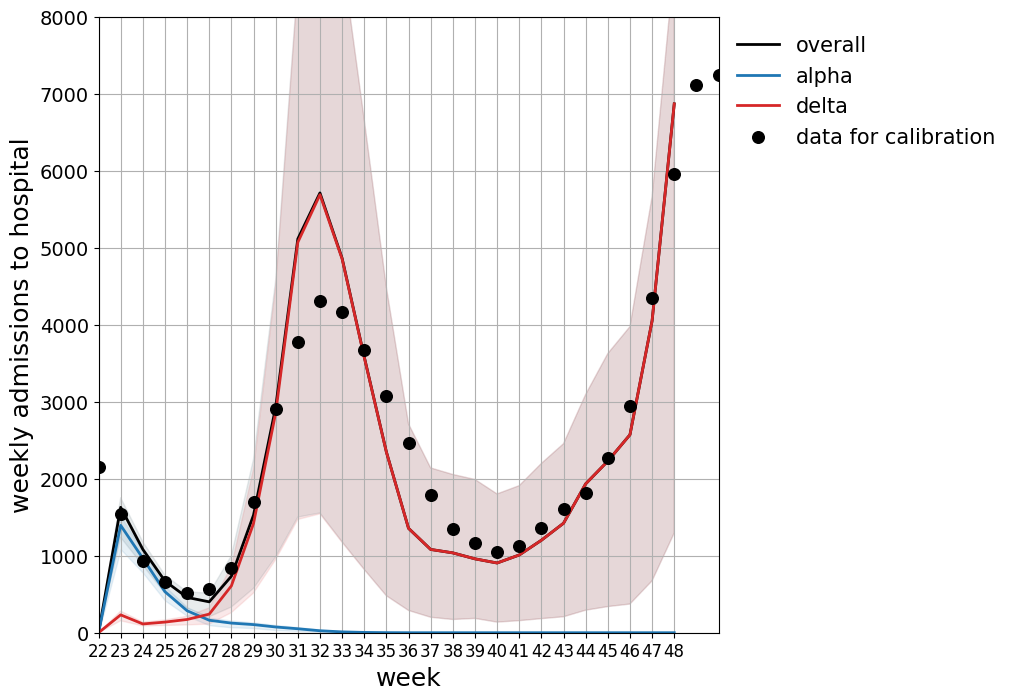

In [65]:
from matplotlib.transforms import blended_transform_factory

folder = 'output_hosp_adm'

fig, ax = plt.subplots(1, 1, figsize=(8,8))

df = pd.read_csv('{}/new_H_{}_scenario_fit_runs{}_both_both.csv'.format(folder, codice_regione, n_runs))
df = aggregate_week(df)
ax.plot(df.index.values, df['median'].values,color='black',linestyle='-',linewidth=width,label='overall')
ax.fill_between(df.index,df['p1'].values, df['p2'].values,color=colors[0], alpha=0.1)  
plt.xticks(df.index, df.week)

df = pd.read_csv('{}/new_H_{}_scenario_fit_runs{}_Alpha_both.csv'.format(folder, codice_regione, n_runs))
df = aggregate_week(df)
ax.plot(df.index.values, df['median'].values,color='tab:blue',linestyle='-',linewidth=width,label='alpha')
ax.fill_between(df.index,df['p1'].values, df['p2'].values,color='tab:blue', alpha=0.1)  

df = pd.read_csv('{}/new_H_{}_scenario_fit_runs{}_Delta_both.csv'.format(folder, codice_regione, n_runs))
df = aggregate_week(df)
ax.plot(df.index.values, df['median'].values,color='tab:red',linestyle='-',linewidth=width,label='delta')
ax.fill_between(df.index,df['p1'].values, df['p2'].values,color='tab:red', alpha=0.1)  

plt.xticks(df.index, df.week, fontsize=12)

plt.yticks( fontsize=14)
ax.set_ylabel('weekly admissions to hospital', fontsize=18)

plt.ylim(0,8000)
plt.xlim(1,29)
ax.scatter(H_adm_week['abs_week']-(53+starting_week-1),H_adm_week['hosp_pred'], color='black',s=70,zorder=10,label='data for calibration')

#plt.axhline(y=peak_1, color='grey', linestyle='--')
#plt.axhline(y=peak_2, color='grey', linestyle='--')
#plt.axhline(y=peak_3, color='grey', linestyle='--')
#plt.text(20, peak_1+200, '1st wave')
#plt.text(20, peak_2-400, '2nd wave')
#plt.text(10, peak_3+200, '3rd wave')

leg = ax.legend(fontsize=15, loc='upper left', bbox_to_anchor=(1,1))
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_color('None')        
plt.subplots_adjust(hspace = 0.1)
plt.xlabel('week',fontsize=18)
#plt.title('{}% VOC delta, scaling f {}, \n scenario summer 2020 w{}'.format(100*prev_delta, 
#                                                        scale2[53+23], week_summer),fontsize=20)

#trans = blended_transform_factory(x_transform=ax.transData, y_transform=ax.transAxes)
#ax.text(x=df[df['week']==22].index[0], y=-0.15, s='|', transform=trans)
#ax.text(x=df[df['week']==26].index[0], y=-0.15, s='|', transform=trans)
#ax.text(x=df[df['week']==30].index[0], y=-0.15, s='|', transform=trans)
#ax.text(x=df[df['week']==34].index[0], y=-0.15, s='|', transform=trans)
#ax.text(x=df[df['week']==39].index[0], y=-0.15, s='|', transform=trans)

#ax.text(x=df[df['week']==23].index[0], y=-0.15, s='JUNE', transform=trans, fontsize=10)
#ax.text(x=df[df['week']==27].index[0], y=-0.15, s='JULY', transform=trans, fontsize=10)
#ax.text(x=df[df['week']==31].index[0], y=-0.15, s='AUGUST', transform=trans, fontsize=10)
#ax.text(x=df[df['week']==35].index[0], y=-0.15, s='SEPTEMBER', transform=trans, fontsize=10)

plt.grid()

plt.savefig('{}/plot_curve.png'.format(folder), bbox_inches='tight',dpi=300)

## extract configuration for Delta vs Omicron code

In [73]:
folder = 'output_extract_config'
from pathlib import Path
Path(folder).mkdir(parents=True, exist_ok=True)

In [74]:
days_to_extract = calendar[calendar[0]=='2021-10-10'][0].apply(lambda x: x.strftime('%Y-%m-%d')).values
days_to_extract

array(['2021-10-10'], dtype=object)

In [75]:
for day in days_to_extract:
    
    res = {}
    for kk in out['prev_comp'].keys():
        res[kk] = out['prev_comp'][kk].iloc[calendar[calendar[0]==day].index[0]]
    
    pd.DataFrame(res).to_csv('./{}/config_{}.csv'.format(folder,day), index=False)
    